<a href="https://colab.research.google.com/github/SarahLares/Classify_Radio_Signals_from_Space_with_keras/blob/master/Classify_Radio_Signals_from_Space_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classify Radio Signals from Space with Keras

We use 2D Spectrograms of deep-space radio signals collected by the antennas at the SETI institute.

The SETI Institute is a non-profit research organization whose mission is to explore, understand, and explain the origin and nature of life in the universe, and apply the knowledge gained to inspire and guide present and future generations. Their goal is the discovery and exchange of knowledge as scientific ambassadors for the public, the press and the government. SETI stands for "search for extraterrestrial intelligence".

The Allen Telescope Array (also abbreviated as ATA) represents the joint effort of the SETI Institute and the Radio Astronomy Laboratory at the University of California, Berkeley to build an interferometry radio telescope (or "radiointerferometer") that is dedicated to both astronomical observations and the simultaneous search for Extraterrestrial Intelligence.

The ATA is currently under construction at the Hat Creek Astronomical Observatory, 450 kilometers from San Francisco, California. When finished, it will consist of 350 antennas. The first phase with 42 antennas (ATA-42) is already complete and began operating on October 11, 2007.

The goal of the ATA is to search for faint but persistent signals.

The current signal detection system is programmed for only particular kinds of signals such as narrow-band carrier waves however, the detection system sometimes triggers the signals that are not narrow-band signals with some unknown efficiency and are also not explicitly known frequency interference. So there seem to be various categories of these kinds of events that have been observed in the recent past so our goal is to build an image classification model to classify these signals accurately.

So the original signals were not 2-D spectrograms but were time-series data collected and downloaded by [SETI](https://www.seti.org/). We’re going to work with 2-D spectrograms which were created by transforming the input time-series data. So we’re going to use the spectrograms as images to train or classification model.

## First, We Import Libraries

In [91]:
!pip3 install livelossplot

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from livelossplot.tf_keras import PlotLossesCallback
import tensorflow as tf
import keras


from sklearn.metrics import confusion_matrix
from sklearn import metrics

import numpy as np
np.random.seed(42)
import warnings;warnings.simplefilter('ignore')

%matplotlib inline


## Load and Preprocess SETI Data

we have two data sets, one for the train (3200 images an labels) and other for the validation (800 images an labels). Each set have two files, the images.csv contains the spectrograph images their raw pixel intensity values ​​and are normalized so that the values ​​are between 0 and 1. They are then converted to a matrix by stretching them. Therefore, each row in the CSV file corresponds to a single image.

The labels.csv file contain the class for each image, so each row correspond to a image.

The label were found to be one hot encoded in to a vector of 1,4 dimension
(no. of classes).

The four types of signals are:

* Squiggle
* Narrow-band
* Noise
* Narrow-band-drd

In [6]:
!unzip dataset

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/train/
  inflating: dataset/train/images.csv  
  inflating: dataset/train/labels.csv  
   creating: dataset/validation/
  inflating: dataset/validation/images.csv  
  inflating: dataset/validation/labels.csv  


In [74]:
train_images = pd.read_csv('dataset/train/images.csv', header=None)
train_labels = pd.read_csv('dataset/train/labels.csv', names=['Squiggle','Narrow-band','Noise','Narrow-band-drd'])

val_images = pd.read_csv('dataset/validation/images.csv', header=None)
val_labels = pd.read_csv('dataset/validation/labels.csv', names=['Squiggle','Narrow-band','Noise','Narrow-band-drd'])

We load the data into dataframes with the function from pandas *read_csv()*, the parameter *head=None* specify that the data don't require a header in the table images. 

In [20]:
train_images.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,8152,8153,8154,8155,8156,8157,8158,8159,8160,8161,8162,8163,8164,8165,8166,8167,8168,8169,8170,8171,8172,8173,8174,8175,8176,8177,8178,8179,8180,8181,8182,8183,8184,8185,8186,8187,8188,8189,8190,8191
0,0.631373,0.623529,0.713726,0.705882,0.658824,0.666667,0.654902,0.635294,0.647059,0.705882,0.729412,0.725490,0.619608,0.674510,0.643137,0.705882,0.713726,0.658824,0.615686,0.690196,0.654902,0.525490,0.556863,0.541176,0.482353,0.588235,0.615686,0.600000,0.603922,0.627451,0.678431,0.658824,0.698039,0.576471,0.678431,0.686275,0.690196,0.705882,0.705882,0.643137,...,0.650980,0.666667,0.666667,0.709804,0.682353,0.682353,0.682353,0.658824,0.682353,0.643137,0.627451,0.623529,0.650980,0.721569,0.627451,0.635294,0.709804,0.690196,0.678431,0.647059,0.658824,0.682353,0.654902,0.694118,0.741176,0.678431,0.662745,0.729412,0.694118,0.647059,0.682353,0.611765,0.650980,0.658824,0.600000,0.603922,0.654902,0.694118,0.658824,0.666667
1,0.725490,0.752941,0.749020,0.701961,0.690196,0.721569,0.709804,0.745098,0.654902,0.721569,0.678431,0.709804,0.713726,0.686275,0.717647,0.713726,0.694118,0.690196,0.721569,0.701961,0.698039,0.713726,0.705882,0.756863,0.756863,0.694118,0.650980,0.674510,0.752941,0.725490,0.725490,0.760784,0.678431,0.717647,0.725490,0.682353,0.709804,0.729412,0.721569,0.717647,...,0.686275,0.670588,0.713726,0.733333,0.725490,0.694118,0.694118,0.686275,0.674510,0.729412,0.721569,0.701961,0.682353,0.709804,0.756863,0.698039,0.729412,0.721569,0.674510,0.698039,0.725490,0.733333,0.666667,0.682353,0.701961,0.737255,0.745098,0.725490,0.698039,0.650980,0.721569,0.698039,0.721569,0.686275,0.713726,0.682353,0.690196,0.698039,0.701961,0.725490
2,0.717647,0.701961,0.713726,0.733333,0.705882,0.717647,0.725490,0.682353,0.717647,0.674510,0.690196,0.670588,0.662745,0.666667,0.713726,0.701961,0.721569,0.713726,0.662745,0.698039,0.682353,0.639216,0.717647,0.658824,0.674510,0.639216,0.643137,0.635294,0.654902,0.682353,0.639216,0.733333,0.690196,0.658824,0.686275,0.658824,0.690196,0.698039,0.709804,0.650980,...,0.533333,0.572549,0.537255,0.549020,0.670588,0.690196,0.670588,0.643137,0.662745,0.713726,0.717647,0.721569,0.709804,0.674510,0.709804,0.686275,0.658824,0.694118,0.698039,0.694118,0.678431,0.678431,0.690196,0.662745,0.650980,0.650980,0.686275,0.631373,0.666667,0.701961,0.709804,0.694118,0.705882,0.682353,0.639216,0.713726,0.670588,0.678431,0.737255,0.674510
3,0.705882,0.674510,0.654902,0.678431,0.666667,0.662745,0.678431,0.662745,0.686275,0.686275,0.631373,0.650980,0.670588,0.737255,0.674510,0.615686,0.670588,0.705882,0.686275,0.678431,0.694118,0.647059,0.662745,0.682353,0.654902,0.721569,0.709804,0.631373,0.670588,0.674510,0.701961,0.725490,0.666667,0.647059,0.733333,0.682353,0.678431,0.603922,0.666667,0.713726,...,0.670588,0.705882,0.749020,0.662745,0.564706,0.623529,0.674510,0.709804,0.658824,0.631373,0.705882,0.670588,0.658824,0.690196,0.674510,0.658824,0.635294,0.682353,0.682353,0.639216,0.666667,0.654902,0.647059,0.670588,0.682353,0.639216,0.705882,0.729412,0.674510,0.666667,0.639216,0.662745,0.631373,0.643137,0.705882,0.662745,0.705882,0.666667,0.654902,0.631373
4,0.647059,0.729412,0.701961,0.674510,0.611765,0.698039,0.713726,0.662745,0.701961,0.674510,0.631373,0.709804,0.694118,0.698039,0.666667,0.690196,0.690196,0.682353,0.682353,0.647059,0.678431,0.658824,0.760784,0.729412,0.674510,0.694118,0.698039,0.713726,0.690196,0.698039,0.686275,0.705882,0.662745,0.670588,0.705882,0.682353,0.690196,0.733333,0.709804,0.701961,...,0.639216,0.690196,0.662745,0.658824,0.662745,0.698039,0.603922,0.690196,0.627451,0.627451,0.654902,0.725490,0.650980,0.717647,0.666667,0.709804,0.682353,0.674510,0.721569,0.741176,0.635294,0.615686,0.674510,0.690196,0.658824,0.694118,0.701961,0.670588,0.721569,0.780392,0.639216,0.670588,0.705882,0.674510,0.721569,0.694118,0.674510,0.705882,0.749020,0.729412


In [76]:
print('number of samples with label Squiggle: ', int(train_labels['Squiggle'].sum()))
print('number of samples with label Narrow-band: ', int(train_labels['Narrow-band'].sum()))
print('number of samples with label Noise: ', int(train_labels['Noise'].sum()))
print('number of samples with label Narrow-band-drd: ', int(train_labels['Narrow-band-drd'].sum()))

number of samples with label Squiggle:  800
number of samples with label Narrow-band:  800
number of samples with label Noise:  800
number of samples with label Narrow-band-drd:  800


We can see that the data is balanced equally between the classes

In [22]:
print("Training set shape:", train_images.shape, train_labels.shape)
print("Validation set shape:", val_images.shape, val_labels.shape)

Training set shape: (3200, 8192) (3200, 4)
Validation set shape: (800, 8192) (800, 4)


The images are rendered in a single row, so now we reshape each row from train_images and val_images as a vector  with the dimensions 64 x 128 (representing the width and height of the image). For this is used the reshape function from pandas, and the set are renamed as **x** for the features an **y** for the target.

Also, we converted the data frames into the array format(.values) because our neural network can’t take in the DataFrame format and our image classifier wants the data to be in that specific format which was achieved after reshaping.

In [97]:
x_train = train_images.values.reshape(3200, 64, 128, 1)
x_val = val_images.values.reshape(800, 64, 128, 1)

y_train = train_labels.values
y_val = val_labels.values

## Plot 2D Spectrograms

With matplotlib we plot four spectrograms randomly in 2D graph

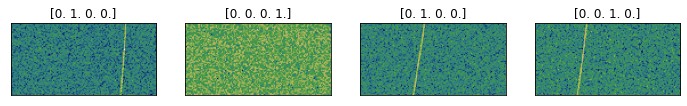

In [79]:
plt.figure(0, figsize=(12,12))
for i in range(1,5):
    plt.subplot(1,4,i)
    r = np.random.randint(0, x_train.shape[0])
    img = np.squeeze(x_train[r])
    plt.xticks([])
    plt.yticks([])
    plt.title(y_train[r])
    plt.imshow(img,cmap="gist_earth_r")

## Create Training and Validation Data Generators

In [94]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True)
datagen_train.fit(x_train)

datagen_val = ImageDataGenerator(horizontal_flip=True)
datagen_val.fit(x_val)

We will use the TensorFLow ImageDataGenerator function. This feature generates batches of tensor image data with real-time data augmentation. The horizontal_flip argument flip inputs horizontally at random.

## Creating the CNN Model

The model that we will use to classify the images is a type of artificial supervised neural network called **Convolutional Neural Network** (CNN).

As, its application is done in two-dimensional matrices, they are effective to perform image classification tasks.


This network processes its layers imitating the visual cortex of the human eye to identify different characteristics at the entrances that ultimately make it able to identify objects and "see." For this, CNN contains several specialized hidden layers with a hierarchy: this means that the first layers can detect lines, curves and specialize until they reach deeper layers that recognize complex shapes such as a face or the silhouette of an animal .

The network for CNN has multiple layers such as convolution layers, maxpool layers for down-sampling, dropout for regularization, and all these layers followed by one or more fully-connected layers at the end. So at each layer, a small neuron process portion of input images and output of these collections are then tiled so that the input region overlap to obtain a high-resolution representation of the input image, and this process is repeated for every such layer.



We import the necessary libraries fom **Keras** for the model.

In [103]:
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

We will use a neural network with two convolution layers, the first with the filter 32 and second with filter 64, this filters means the number of output filters in the convolution. The kernel size for both layers are (5,5), the activation functior are relu and we use max pooling (2,2)

In [82]:
# Initialising the CNN
model = Sequential()

# 1st Convolution
model.add(Conv2D(32,(5,5), padding='same', input_shape=(64, 128,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Convolution layer
model.add(Conv2D(64,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Flattening
model.add(Flatten())

# Fully connected layer
model.add(Dense(1024))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.4))

model.add(Dense(4, activation='softmax'))

## Learning Rate Scheduling and Compile the Model

In [83]:
initial_learning_rate = 0.005
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=5,
    decay_rate=0.96,
    staircase=True)

optimizer = Adam(learning_rate=lr_schedule)

This will keep decreasing the learning rate like 0.005 x (0.96 5) = 0.004076 after each step.

In [95]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 128, 32)       832       
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 128, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 64, 128, 32)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 64, 64)        51264     
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 64, 64)        2

## Training the Model

In [105]:
checkpoint = ModelCheckpoint("model_weights.h5", monitor='val_loss',
                             save_weights_only=True, mode='min', verbose=0)
callbacks = [checkpoint]#, reduce_lr]
batch_size = 32
history = model.fit(
    datagen_train.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
    steps_per_epoch=len(x_train)//batch_size,
    validation_data = datagen_val.flow(x_val, y_val, batch_size=batch_size, shuffle=True),
    validation_steps = len(x_val)//batch_size,
    epochs=12,
    callbacks=callbacks
)

Epoch 1/12
100/100 [==============================] - 118s 1s/step - loss: 0.5580 - accuracy: 0.7003 - val_loss: 3.5912 - val_accuracy: 0.2500
Epoch 2/12
100/100 [==============================] - 121s 1s/step - loss: 0.4019 - accuracy: 0.7553 - val_loss: 4.3698 - val_accuracy: 0.2500
Epoch 3/12
100/100 [==============================] - 117s 1s/step - loss: 0.3857 - accuracy: 0.7475 - val_loss: 4.8636 - val_accuracy: 0.2500
Epoch 4/12
100/100 [==============================] - 117s 1s/step - loss: 0.3828 - accuracy: 0.7450 - val_loss: 4.1058 - val_accuracy: 0.2500
Epoch 5/12
100/100 [==============================] - 117s 1s/step - loss: 0.3740 - accuracy: 0.7531 - val_loss: 3.4121 - val_accuracy: 0.4338
Epoch 6/12
100/100 [==============================] - 117s 1s/step - loss: 0.3707 - accuracy: 0.7559 - val_loss: 1.8662 - val_accuracy: 0.4950
Epoch 7/12
100/100 [==============================] - 120s 1s/step - loss: 0.3637 - accuracy: 0.7597 - val_loss: 0.4029 - val_accuracy: 0.7412

## Model Evaluation

In [106]:
model.evaluate(x_val, y_val)

25/25 [==============================] - 5s 200ms/step - loss: 0.3661 - accuracy: 0.7513


[0.36607760190963745, 0.7512500286102295]

In [107]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns

y_true = np.argmax(y_val, 1)
y_pred = np.argmax(model.predict(x_val), 1)
print(metrics.classification_report(y_true, y_pred))
print("Classification accuracy: %0.6f" % metrics.accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       200
           1       0.51      0.24      0.33       200
           2       0.50      0.78      0.61       200
           3       1.00      1.00      1.00       200

    accuracy                           0.75       800
   macro avg       0.75      0.75      0.73       800
weighted avg       0.75      0.75      0.73       800

Classification accuracy: 0.751250


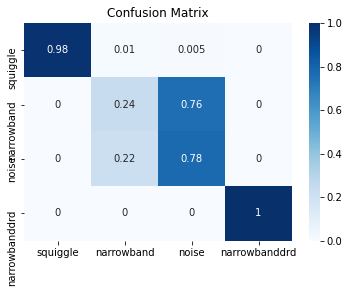

In [108]:
labels = ["squiggle", "narrowband", "noise", "narrowbanddrd"]

ax= plt.subplot()
sns.heatmap(metrics.confusion_matrix(y_true, y_pred, normalize='true'), annot=True, ax = ax, cmap=plt.cm.Blues); #annot=True to annotate cells

# labels, title and ticks
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);